Goal of this notebook: map out the parameter space for the saulcopter.

The Saulcopter is a little plane that flies around Saul's head in circles and is tied to Saul with a rope. Some parameters of interest:

* Wingspan
* Rope Length
* Circling Radius
* Power Draw

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

Saul doesn't want to be swung around in circles, so his pendulum period must be longer than the circling time:

$2\pi\sqrt{l/g} >> 2\pi R / v$

Saul weighs 100 kg, so we need that much lift:

$F_L = \frac{1}{2} \rho C_L A v^2 = 1000 N$

In [3]:
LDRATIO = 30. # Lift-to-Drag ratio, 10 is probably more realistic

In [4]:
VV = 100. #m/sec, airspeed

In [5]:
SAUL = 1000. #N

In [6]:
RHO_AIR = 1. #kg/m^3, density of air

In [7]:
CL_A = SAUL * 2 / VV**2 / RHO_AIR # coefficient of lift times wing area
print CL_A

0.2


In [8]:
CD_A = CL_A / LDRATIO # coefficient of drag times wing area

wingspan = 10 # m
chord = 0.5 #m

AR = 8 #standard wingspan/chord aspect ratio

Pp = 0.5 * RHO_AIR * CD_A * VV**3
print 'Power Draw:\t%2.2f kW'%(Pp/1000)

Power Draw:	3.33 kW


In [9]:
CD = 0.1 #typical drag coef
AA = CD_A / CD

wingspan = (AA * AR)**0.5
print 'Wingspan:\t%2.2f m'%wingspan

chord = wingspan / AR
print 'Chord:\t\t%2.2f m'%chord

Wingspan:	0.73 m
Chord:		0.09 m


In [10]:
ARB1 = 10 # arbitrary choice of radius to wingspan ratio, should be >> 1
ARB2 = 10 # arbitrary choice of load pendulum period to circling period, should be >> 1

In [11]:
RR = wingspan * ARB1 #circle radius
print 'Circle Radius:\t%2.2f m'%RR

GG = 10 #m/s^2
LL = max(ARB2 * GG * (RR / VV)**2, RR*(2.**0.5))
print 'Rope Length:\t%2.2f m'%LL

from math import asin, pi
angle = asin(RR / LL) * 180/pi
print 'Rope Angle:\t%2.1f deg'%angle

Circle Radius:	7.30 m
Rope Length:	10.33 m
Rope Angle:	45.0 deg


Now functionalize this and bound design space

In [12]:
ldratio = np.linspace(1, 30)
vv = np.linspace(1, 100)

DESIGN_LOAD = 1000 # N
CD = 0.1 # drag coef of airfoil
AR = 8. # aspect ratio of wing

FLIGHTTIME = 1 #hr, how long should the thing fly
SPEC_ENERGY = 100 # W*hr / kg, specific energy density of battery (bad lithium ion)

def CL_A(vv):
    ''' lift coef times wing area '''
    return DESIGN_LOAD * 2 / VV**2 / RHO_AIR

def CD_A(vv, ldratio):
    ''' drag coef times wing area '''
    return CL_A(vv) / ldratio

def Pp(vv, ldratio):
    ''' power draw '''
    return 0.5 * RHO_AIR * CD_A(vv, ldratio) * vv**3

def battery_load(vv, ldratio):
    ''' weight of batteries '''
    energy = Pp(vv, ldratio) * FLIGHTTIME
    return energy / SPEC_ENERGY

def wingspan(vv, ldratio):
    ''' wingspan of airplane '''
    AA = CD_A(vv, ldratio) / CD
    return (AA * AR)**0.5

def RR(vv, ldratio):
    ''' circling radius of airplane '''
    return 10 * wingspan(vv, ldratio)

def LL(vv, ldratio):
    ''' length of rope '''
    this_rr = RR(vv, ldratio)
    return np.maximum(10 * GG * (this_rr / vv)**2, this_rr*(2.**0.5))

<matplotlib.colorbar.Colorbar instance at 0x7f112cbbf3f8>

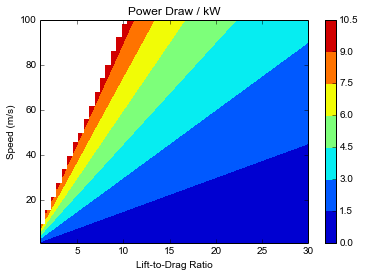

In [13]:
LDRATIO, VV = np.meshgrid(ldratio, vv)
POWER = Pp(VV, LDRATIO)
POWER = np.where(POWER < 1e4, POWER, float('nan'))
plt.contourf(LDRATIO, VV, POWER / 1e3)
plt.xlabel('Lift-to-Drag Ratio')
plt.ylabel('Speed (m/s)')
plt.title('Power Draw / kW')
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7f112ca49560>

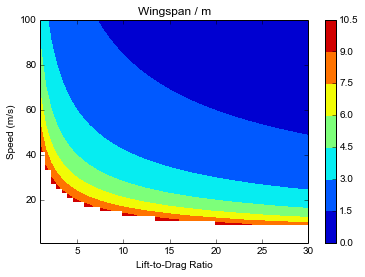

In [14]:
WINGSPAN = wingspan(VV, LDRATIO)
WINGSPAN = np.where(WINGSPAN < 10, WINGSPAN, float('nan'))
plt.contourf(LDRATIO, VV, WINGSPAN)
plt.xlabel('Lift-to-Drag Ratio')
plt.ylabel('Speed (m/s)')
plt.title('Wingspan / m')
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7f112c9f9488>

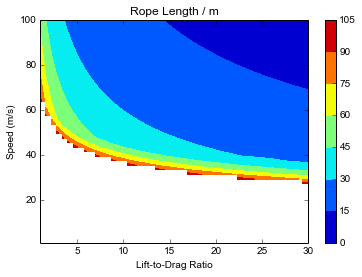

In [15]:
MAXROPE = 100

ROPELENGTH = LL(VV, LDRATIO)
ROPELENGTH = np.where(ROPELENGTH < MAXROPE, ROPELENGTH, float('nan'))
plt.contourf(LDRATIO, VV, ROPELENGTH)
plt.xlabel('Lift-to-Drag Ratio')
plt.ylabel('Speed (m/s)')
plt.title('Rope Length / m')
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7f112c77c320>

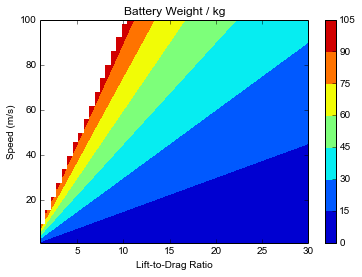

In [16]:
BATT_LOAD = battery_load(VV, LDRATIO)
BATT_LOAD = np.where(BATT_LOAD < 0.1 * DESIGN_LOAD, BATT_LOAD, float('nan'))
plt.contourf(LDRATIO, VV, BATT_LOAD)
plt.xlabel('Lift-to-Drag Ratio')
plt.ylabel('Speed (m/s)')
plt.title('Battery Weight / kg')
plt.colorbar()

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:5: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:6: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:7: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:8: RuntimeWarning: invalid value encountered in less


<matplotlib.colorbar.Colorbar instance at 0x7f112c65c050>

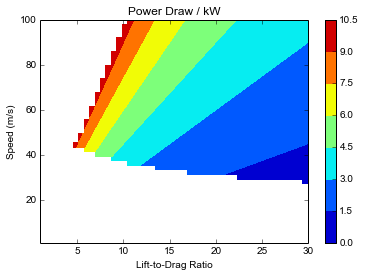

In [17]:
# Plot power draw subject to all design constraints

LDRATIO, VV = np.meshgrid(ldratio, vv)
POWER2 = Pp(VV, LDRATIO)
POWER2 = np.where(POWER < 1e4, POWER, float('nan'))
POWER2 = np.where(WINGSPAN < 10, POWER2, float('nan'))
POWER2 = np.where(ROPELENGTH < 100, POWER2, float('nan'))
POWER2 = np.where(BATT_LOAD < 0.1 * DESIGN_LOAD, POWER2, float('nan'))

plt.contourf(LDRATIO, VV, POWER2 / 1e3)
plt.xlabel('Lift-to-Drag Ratio')
plt.ylabel('Speed (m/s)')
plt.title('Power Draw / kW')
plt.colorbar()